In [1]:
from byol.models import BYOL, ResNetModule
from byol.utils import BYOLTransforms1, BYOLTransforms
import torch
import pytorch_lightning as pl
import torchvision
import numpy as np

accelerator = "gpu" if torch.cuda.is_available() else "cpu"


## Pure Resnet CIFAR-10 classification task

Let's start by setting a baseline of a classification task of our model's backbone. We are using resnet18 here as our backone, so let's see how it performs on a subset of the CIFAR-10 data.

Pipeline:
1. Start with a full dataset of CIFAR-10 training data $D$. 
2. Train a supervised task with resnet18 on a subset $A$ of $D$ and log its score on the test set $T$.
3. Train a unsupervised task with BYOL on a subset $B$ of $D$ (where $D = A \cup B$) and log the the model. 
4. Finetune the BYOL-enhanced model with a supervised task on resnet 18 on the subset $A$. Log its score on test set $T$.
5. Compare results between baseline and finetued model.


#### Step 1. Data

In [2]:
no_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
cifar10_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=no_transform)
cifar10_test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=no_transform)
cifar10_dataset


Files already downloaded and verified
Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

Creating subsets $A$ and $B$.

In [3]:
A_indices = np.random.choice(len(cifar10_dataset), int(len(cifar10_dataset)/2), replace=False)
cifar10_subset_A = torch.utils.data.Subset(cifar10_dataset, A_indices)
train_test_split = 0.8
train_size = int(len(cifar10_subset_A)*train_test_split)
val_size = len(cifar10_subset_A) - train_size
train_dataset_A, val_dataset_A = torch.utils.data.random_split(cifar10_subset_A, [train_size, val_size])

Dataloaders for supervised task.

In [4]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset_A, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset_A, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(cifar10_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

### Step 2: Training ResNet model

In [5]:
resnet_module = ResNetModule()

resnet_trainer = pl.Trainer(
    max_epochs=10,
    devices=1,
    accelerator=accelerator,
)

resnet_trainer.fit(model=resnet_module, train_dataloaders=train_loader, val_dataloaders=val_loader)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 11.2 M
-------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.706    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


### Step 3: Training BYOL model on unlabelled data.

In [6]:
transform = BYOLTransforms(
    view1=BYOLTransforms1(input_size=32),
    view2=BYOLTransforms1(input_size=32)
)

cifar10_dataset_byol = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
B_indices = np.setdiff1d(np.arange(len(cifar10_dataset)), A_indices)
cifar10_subset_B = torch.utils.data.Subset(cifar10_dataset_byol, B_indices)
byol_batch_size = 2048 # byol batch size is usually a lot larger than the supervised batch size
byol_dataloader = torch.utils.data.DataLoader(cifar10_subset_B, batch_size=byol_batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified


In [7]:
byol_module = BYOL()

byol_trainer = pl.Trainer(
    max_epochs=10,
    devices=1,
    accelerator=accelerator,
)

byol_trainer.fit(model=byol_module, train_dataloaders=byol_dataloader) # our model never sees labeled data!

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type               | Params
--------------------------------------------------------------
0 | backbone               | Sequential         | 11.2 M
1 | projection_head        | BYOLProjectionHead | 788 K 
2 | prediction_head        | BYOLPredictionHead | 526 K 
3 | target_backbo

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


### Step 4. Finetune BYOL-enhanced baseline on ResNet

In [9]:
byol_resnet = ResNetModule.from_byol(byol_module)

byol_resnet_trainer = pl.Trainer(
    max_epochs=10,
    devices=1,
    accelerator=accelerator,
)

byol_resnet_trainer.fit(model=byol_resnet, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 11.2 M
-------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.706    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing on test dataset.

In [10]:
predict_transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=predict_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


Files already downloaded and verified


In [12]:
resnet_trainer.test(model=resnet_module, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.1545921564102173     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.1545921564102173}]

In [13]:
byol_resnet_trainer.test(model=byol_resnet, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.0614186525344849     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.0614186525344849}]

In [21]:
num_samples = 10
indices = np.random.choice(len(test_dataset), num_samples, replace=False)
subset_test_dataset = torch.utils.data.Subset(test_dataset, indices)
subset_test_dataloader = torch.utils.data.DataLoader(
    subset_test_dataset, 
    batch_size=2,
    num_workers=8,
    shuffle=False
)

In [22]:
resnet_predictions = resnet_trainer.predict(model=resnet_module, dataloaders=subset_test_dataloader)
byol_resnet_predictions = byol_resnet_trainer.predict(model=byol_resnet, dataloaders=subset_test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

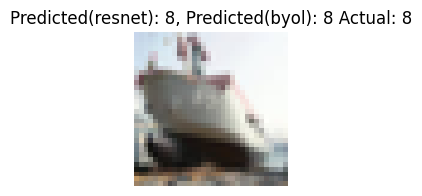

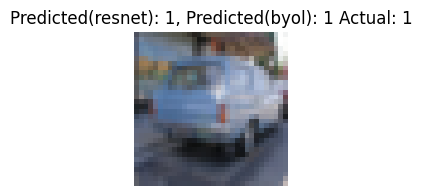

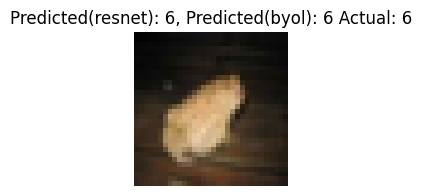

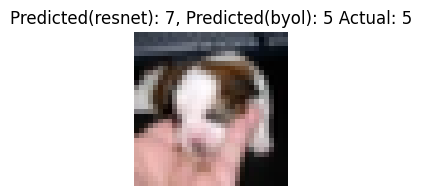

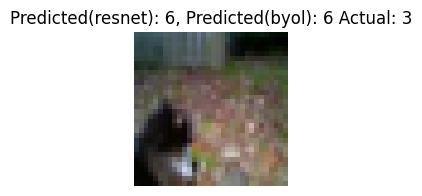

In [23]:
import matplotlib.pyplot as plt

resnet_predicted_labels = torch.argmax(torch.cat(resnet_predictions, dim=0), dim=1)
byol_resnet_predicted_labels = torch.argmax(torch.cat(byol_resnet_predictions, dim=0), dim=1)

# Select a few images to display
num_images_to_display = 5
for i in range(num_images_to_display):
    image, label = subset_test_dataset[i]
    resnet_pred_label = resnet_predicted_labels[i]
    byol_resnet_pred_label = byol_resnet_predicted_labels[i] 

    np_image = image.numpy().transpose((1, 2, 0))
    np_image = np.clip(np_image * 0.5 + 0.5, 0, 1) 

    plt.figure(figsize=(2, 2))
    plt.imshow(np_image)
    plt.title(f'Predicted(resnet): {resnet_pred_label}, Predicted(byol): {byol_resnet_pred_label} Actual: {label}')
    plt.axis('off')
    plt.show()